In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

%matplotlib inline
warnings.filterwarnings("ignore")

### Uploading and cleaning data

In [2]:
data = pd.read_csv("spotify_tracks.csv")

In [3]:
data

,https://www.kaggle.com/datasets/gauthamvijayaraj/spotify-tracks-dataset-updated-every-week,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,track_id,track_name,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language
2,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,2024,59,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",0.0241,0.753,97297,...,8,0.1,-5.994,0,0.103,110.997,4,0.459,https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil
3,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",2024,47,https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,0.0851,0.78,207369,...,10,0.0951,-5.674,0,0.0952,164.995,3,0.821,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil
4,59NoiRhnom3lTeRFaBzOev,Mayakiriye Sirikiriye - Orchestral EDM,"Anirudh Ravichander, Anivee, Alvin Bruno",2024,35,https://i.scdn.co/image/ab67616d0000b27334a1dd...,Mayakiriye Sirikiriye (Orchestral EDM),0.0311,0.457,82551,...,2,0.0831,-8.937,0,0.153,169.996,4,0.598,https://open.spotify.com/track/59NoiRhnom3lTeR...,Tamil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62314,3eHDwMQYPEziy2DWRBNoLv,Sani - G.O.A.T Remix,"Arvind Raj, Sheezay, Music Kitchen, FSPROD Vin...",2021,30,https://i.scdn.co/image/ab67616d0000b273819d23...,Sani (G.O.A.T Remix),0.0849,0.877,359718,...,7,0.11,-11.458,1,0.353,100.024,4,0.504,https://open.spotify.com/track/3eHDwMQYPEziy2D...,Tamil
62315,5hHtCqkNv5eo99OrEFFcgS,Life of Bachelor,"A H Kaashif, Navakkarai Naveen Prabanjam, Asal...",2021,30,https://i.scdn.co/image/ab67616d0000b2736cd651...,Bachelor (Original Motion Picture Soundtrack),0.0788,0.833,154364,...,8,0.267,-5.061,1,0.0813,110.041,4,0.524,https://open.spotify.com/track/5hHtCqkNv5eo99O...,Tamil
62316,08foF9YHgKmIgOy3xMWRZy,Yo Baby,"Rakesh Ambigapathy, Asal Kolaar, MC Vickey",2021,18,https://i.scdn.co/image/ab67616d0000b27300da25...,Yo Baby,0.00918,0.842,234000,...,7,0.079,-5.855,1,0.137,122.038,4,0.669,https://open.spotify.com/track/08foF9YHgKmIgOy...,Tamil
62317,2wLFbVlQGKJSd9lwzwL47F,Fast Fast Vadiley,"Asal Kolaar, Priyadarshan Balasubramanian",2021,1,https://i.scdn.co/image/ab67616d0000b273e051e1...,Arjuna Phalguna,0.101,0.682,180807,...,1,0.32,-6.061,1,0.285,74.993,4,0.439,https://open.spotify.com/track/2wLFbVlQGKJSd9l...,Tamil


In [4]:
data.columns = data.iloc[1] 
data = data[2:]
data.reset_index(drop=True, inplace=True) 

In [5]:
data = data[data["year"] == 2024]

In [6]:
data = data[(data['language'] == 'English') | (data['language'] == 'Tamil') | (data['language'] == 'Hindi') | (data['language'] == 'Korean')]

In [7]:
data = data.loc[:, ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'liveness', 'loudness',	'mode',	'speechiness', 'tempo', 'valence', 'language']]

In [8]:
list_var = data.columns.tolist()

In [9]:
data = data.dropna()

In [10]:
columns = data.columns[0:11]
for s in columns:
    data[s] = pd.to_numeric(data[s], errors='coerce')

In [11]:
data = data[~(data[list_var] == -1).any(axis=1)]

In [12]:
skim(data.filter(list_var))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4064   │ │ float64     │ 8     │                                                          │
│ │ Number of columns │ 12     │ │ int32       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0        ┃ p25     ┃ p50    ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ popularity    │   0 │     0 │   8.132 │   15.02 │         0 │       0 │      1 │      9 │      93 │  ▇▁▁   │  │
│ │ acousticness  │   0 │     0 │  0.3191 │  0.3013 │  4.94e-06 │ 0.04038 │  0.211 │ 0.5613 │   0.996 │ ▇▂▂▂▂▁ │  │
│ │ danceability  │   0 │     0 │  0.6342 │  0.1675 │    0.0615 │   0.577 │  0.657 │  0.743 │   0.968 │ ▁▁▂▇▇▂ │  │
│ │ duration_ms   │   0 │     0 │  213900 │  126500 │     15000 │  175700 │ 203200 │ 233800 │ 2774000 │   ▇    │  │
│ │ energy        │   0 │     0 │  0.5864 │  0.2522 │   0.00134 │   0.417 │ 0.6325 │  0.804 │   0.996 │ ▃▃▃▇▇▇ │  │
│ │ liveness      │   0 │     0 │  0.2009 │  0.1632 │    0.0178 │  0.0927 │   0.13 │  0.279 │   0.963 │  ▇▃▁   │  │
│ │ loudness      │   0 │     0 │  -9.153 │   5.707 │    -39.17 │  -10.77 │ -7.335 │ -5.406 │  -0.704 │   ▁▂▆▇ │  │
│ │ mode          │   0 │     0 │  0.5669 │  0.4956 │         0 │       0 │      1 │      1 │       1 │ ▆    ▇ │  │
│ │ speechiness   │   0 │     0 │  0.1492 │   0.245 │    0.0238 │  0.0397 │ 0.0492 │  0.102 │   0.959 │ ▇▁   ▁ │  │
│ │ tempo         │   0 │     0 │   119.4 │   27.69 │     43.18 │   99.51 │  121.1 │  138.7 │     220 │  ▆▇▅▁  │  │
│ │ valence       │   0 │     0 │  0.5031 │  0.2488 │         0 │  0.3347 │ 0.4925 │  0.695 │   0.989 │ ▃▅▇▆▆▃ │  │
│ └───────────────┴─────┴───────┴─────────┴─────────┴───────────┴─────────┴────────┴────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ language                  │       0 │          0 │                            1 │                     4064 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [13]:
#acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
#danceability: A measure of how suitable a track is for dancing (0.0 = least danceable, 1.0 = most danceable).
#duration_ms: Track length in milliseconds.
#energy: A perceptual measure from 0.0 to 1.0 of intensity and activity.
#liveness: A measure of the likelihood that the track was recorded live (higher values indicate live performances).
#loudness: The overall loudness of the track in decibels (dB).
#mode: Indicates the modality of the track (1 = major, 0 = minor).
#speechiness: Measures the presence of spoken words in a track (closer to 1.0 indicates more speech-like content).
#tempo: The estimated tempo of the track in beats per minute (BPM).
#valence: A measure from 0.0 to 1.0 indicating the track's musical positiveness (higher values are happier)

In [14]:
a = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
     'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'language']
melted = data.melt(id_vars = "language", value_vars = 'speechiness') 
melted = melted.rename(columns={1: 'values'})
melted.groupby(["language", 'values']).agg(["mean", "std", "min", "max", "count"]).round(2)

value                        
                      mean   std   min   max count
language values                                   
English  speechiness  0.17  0.28  0.02  0.96  2829
Hindi    speechiness  0.08  0.07  0.02  0.41   257
Korean   speechiness  0.08  0.08  0.03  0.54   121
Tamil    speechiness  0.10  0.09  0.03  0.90   857

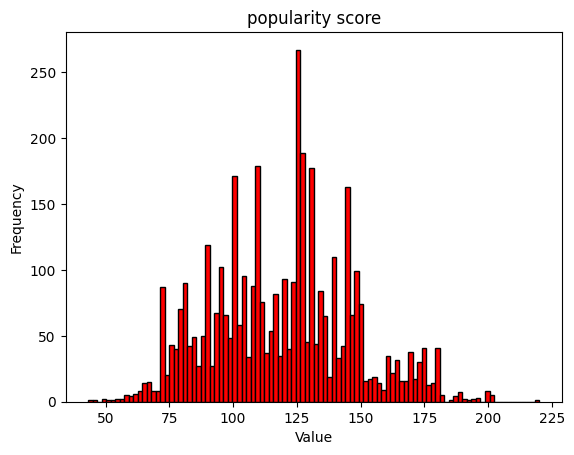

In [15]:
o = 'tempo'
plt.hist(data[o], bins = 100, color='red', edgecolor='black')
plt.title('popularity score')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Popularity and danceability

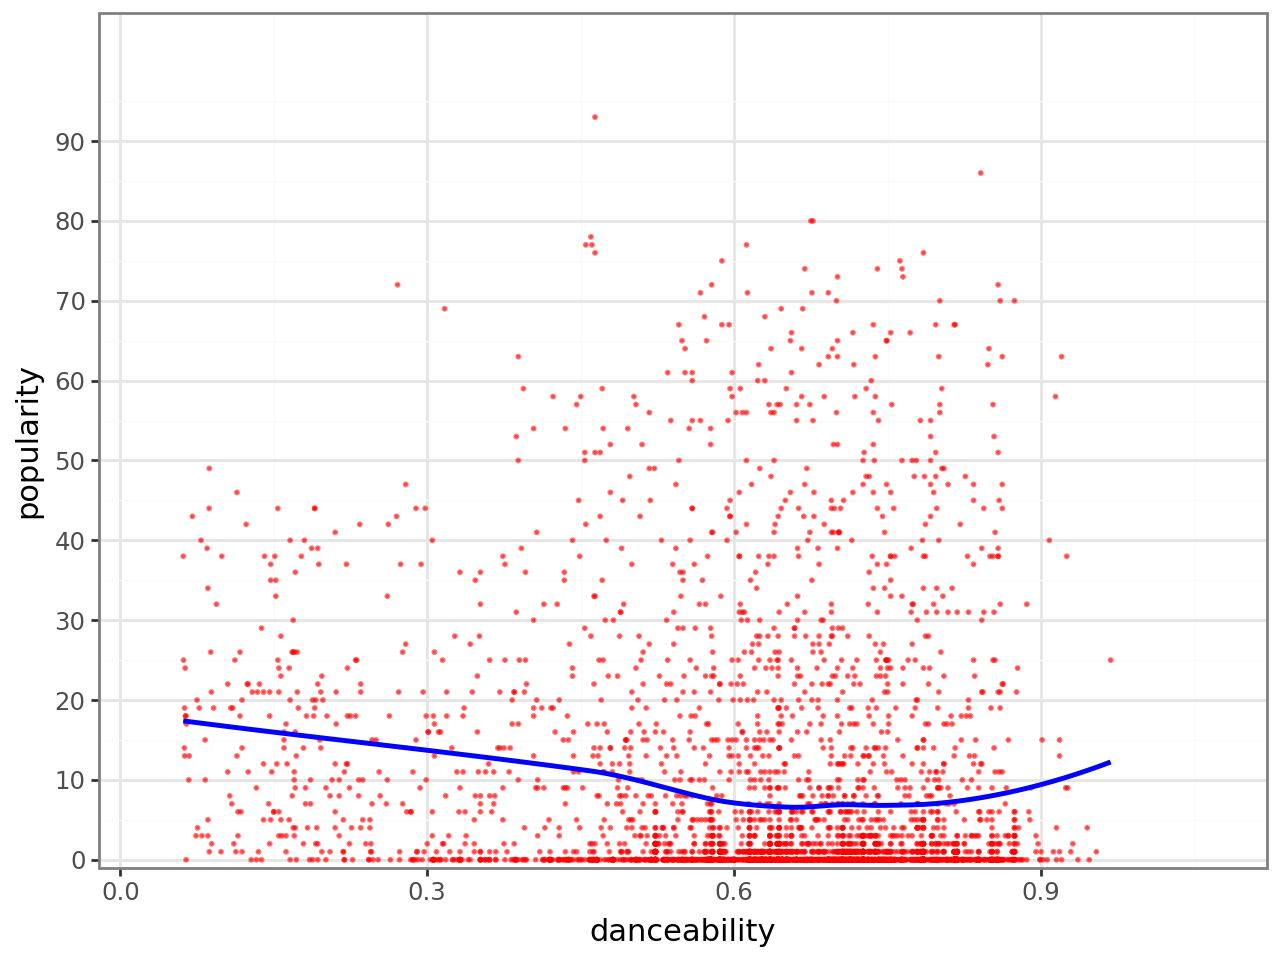

In [16]:
plot = (
    ggplot(data=data)
    + geom_point(aes(x = "danceability", y = "popularity"), color = "red", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x = "danceability", y = "popularity"), method = "loess", color = 'blue', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=( 0, 1.1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 105), breaks=np.arange(0, 100, 10)
    )
    + labs(x = "danceability", y = "popularity")
    + theme_bw()
)
plot

### Popularity and liveness

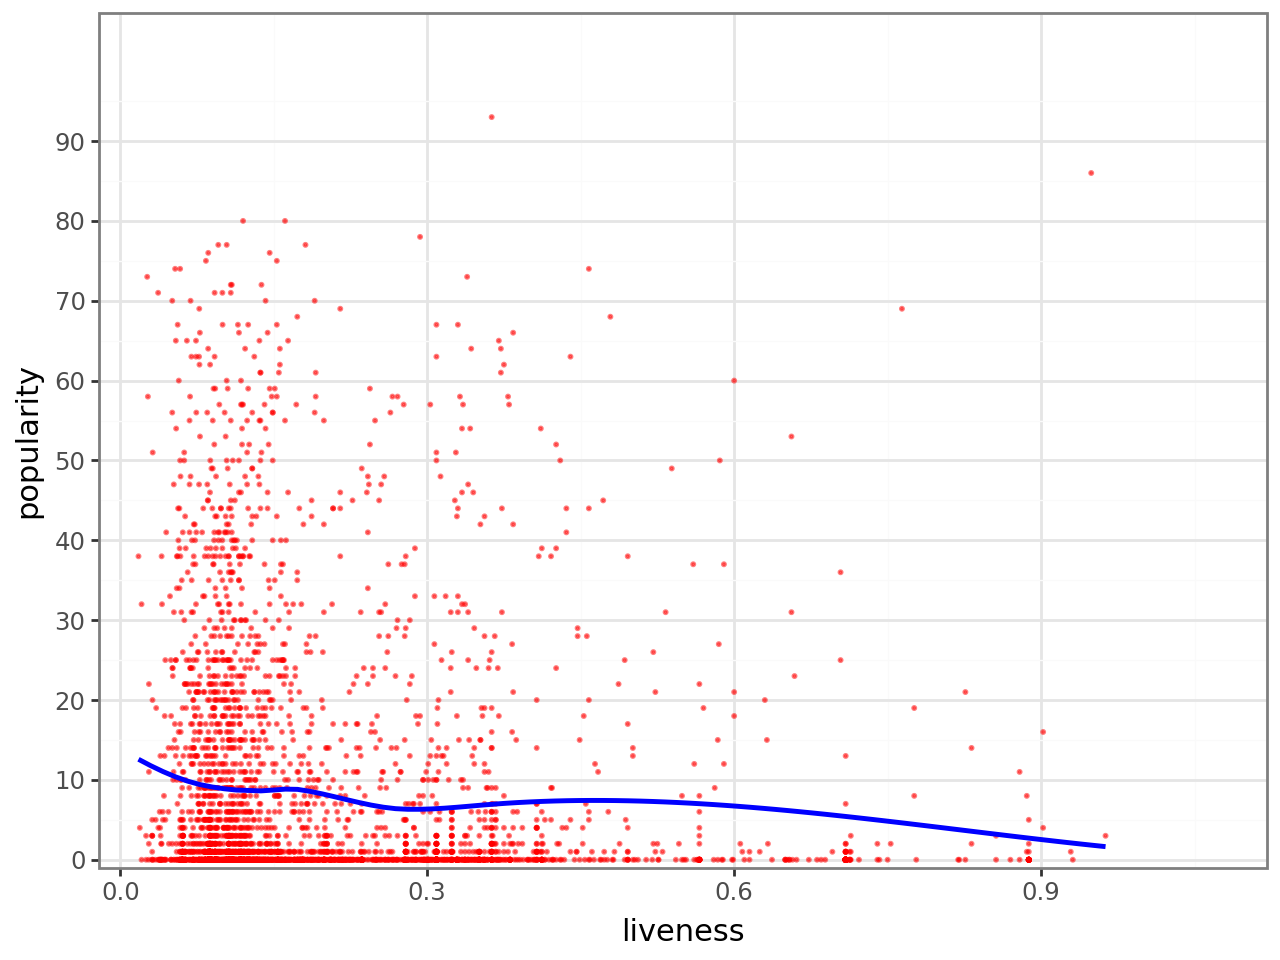

In [17]:
i = 'liveness'
plot = (
    ggplot(data=data)
    + geom_point(aes(x = i, y = "popularity"), color = "red", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x = i, y = "popularity"), method = "loess", color = 'blue', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=( 0, 1.1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 105), breaks=np.arange(0, 100, 10)
    )
    + labs(x = i, y = "popularity")
    + theme_bw()
)
plot

### Popularity and speechness 

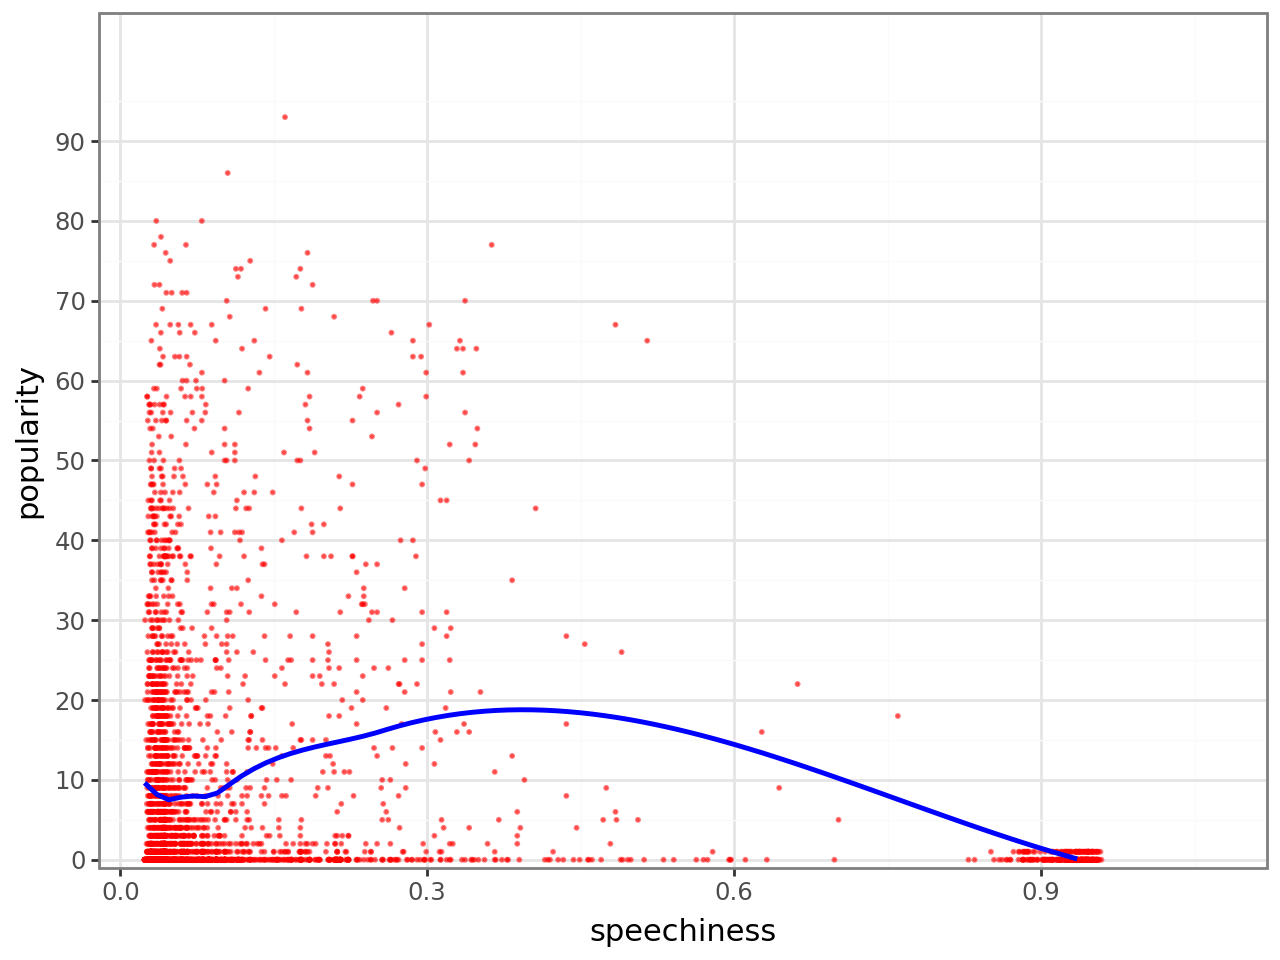

In [18]:
i = 'speechiness'
plot = (
    ggplot(data=data)
    + geom_point(aes(x = i, y = "popularity"), color = "red", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x = i, y = "popularity"), method = "loess", color = 'blue', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=( 0, 1.1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 105), breaks=np.arange(0, 100, 10)
    )
    + labs(x = i, y = "popularity")
    + theme_bw()
)
plot

### Popularity and valence 

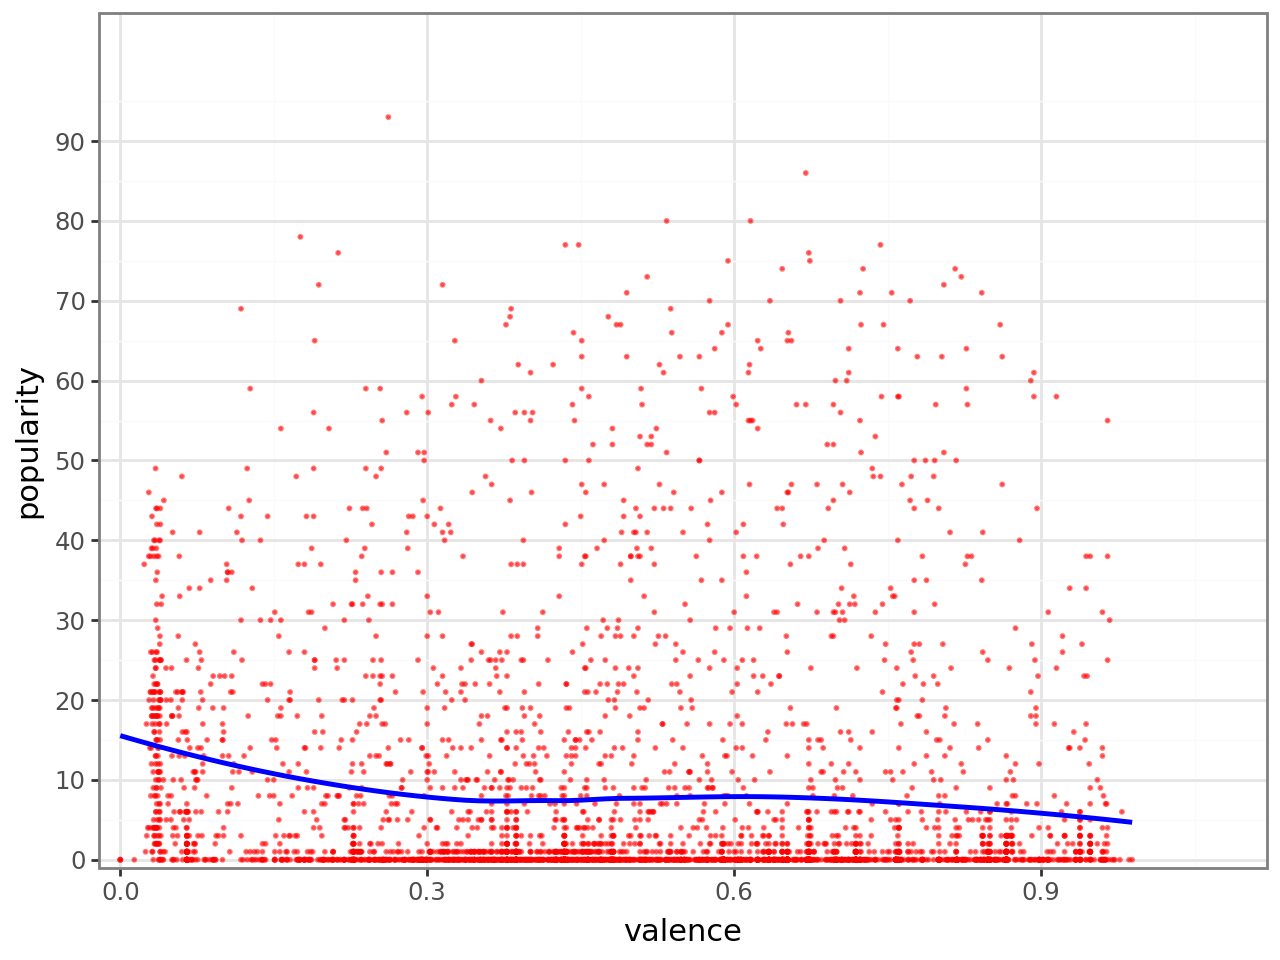

In [19]:
i = 'valence'
plot = (
    ggplot(data=data)
    + geom_point(aes(x = i, y = "popularity"), color = "red", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x = i, y = "popularity"), method = "loess", color = 'blue', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=( 0, 1.1))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 105), breaks=np.arange(0, 100, 10)
    )
    + labs(x = i, y = "popularity")
    + theme_bw()
)
plot

### Popularity and duration_ms

In [20]:
data['log_duration_ms'] = np.log(data['duration_ms'])

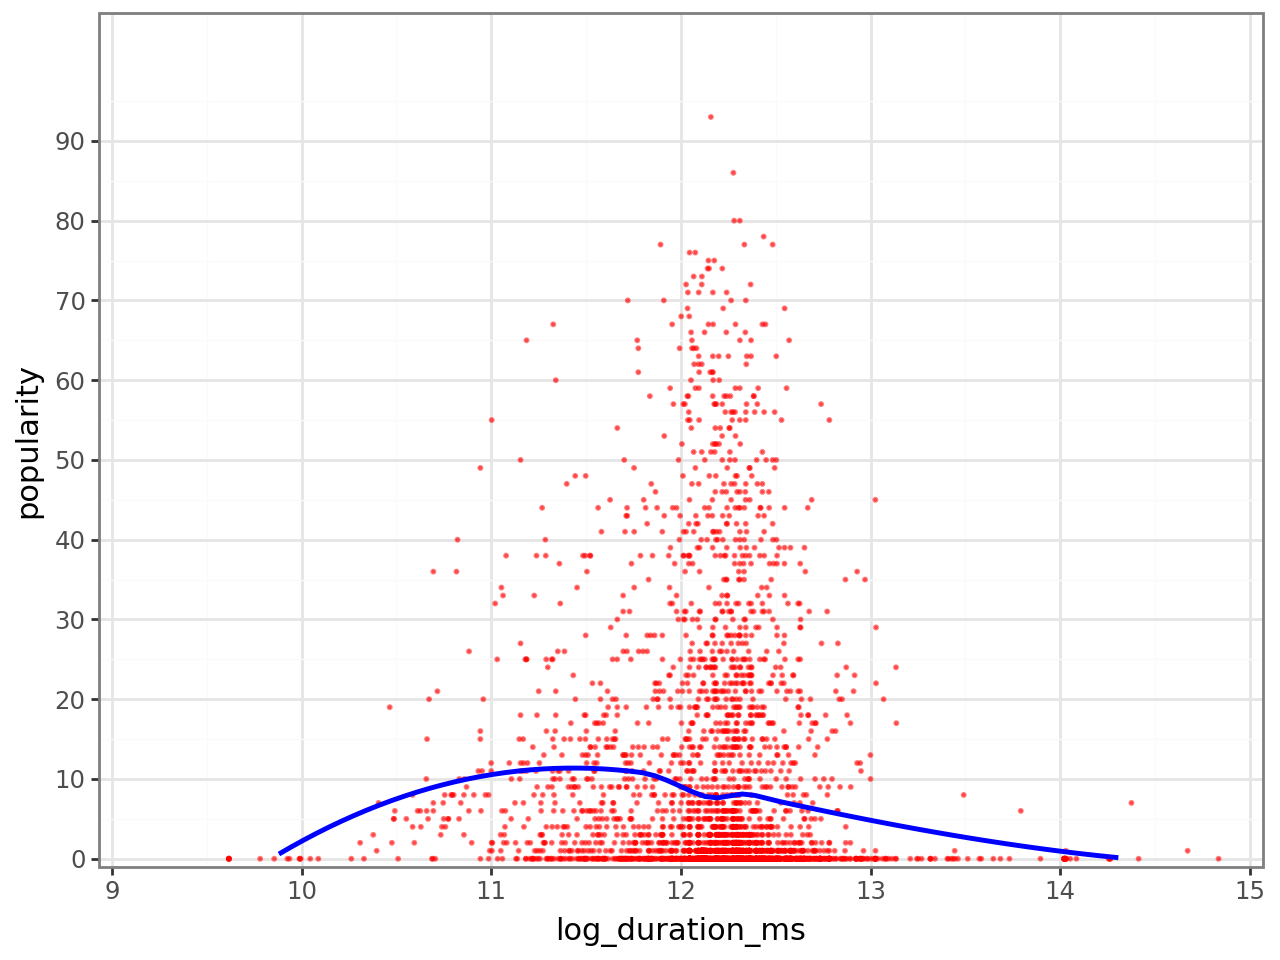

In [21]:
i = 'log_duration_ms'
plot = (
    ggplot(data=data)
    + geom_point(aes(x = i, y = "popularity"), color = "red", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x = i, y = "popularity"), method = "loess", color = 'blue', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=( 9, 15))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 105), breaks=np.arange(0, 100, 10)
    )
    + labs(x = i, y = "popularity")
    + theme_bw()
)
plot

### Popularity and tempo

In [22]:
data['log_tempo'] = np.log(data['tempo'])

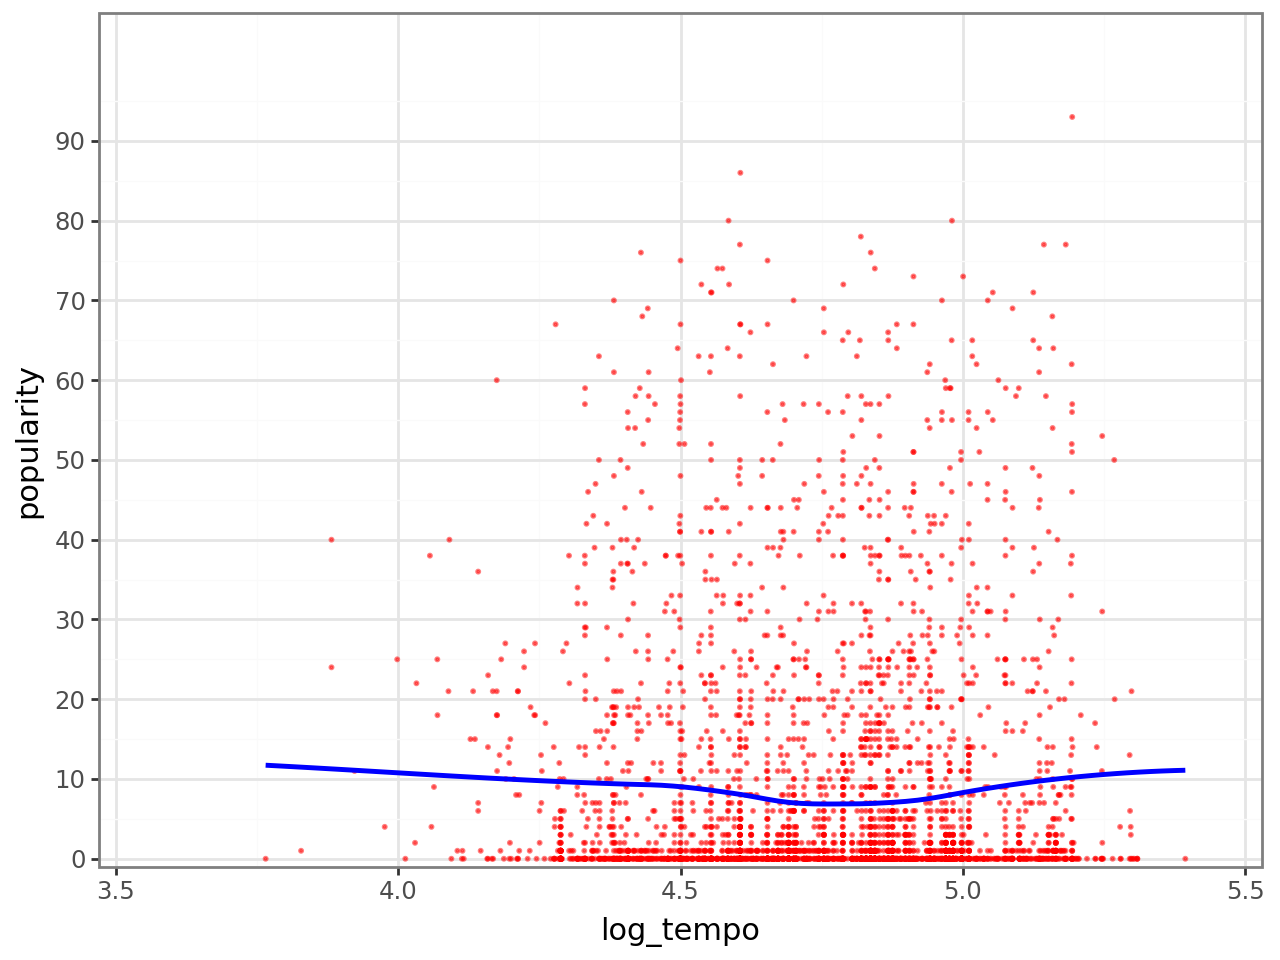

In [23]:
i = 'log_tempo'
plot = (
    ggplot(data=data)
    + geom_point(aes(x = i, y = "popularity"), color = "red", size = 0.2, alpha = 0.5)
    + geom_smooth(aes(x = i, y = "popularity"), method = "loess", color = 'blue', se=False)
    + expand_limits(x = 0.01, y = 0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(3.5, 5.5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 105), breaks=np.arange(0, 100, 10)
    )
    + labs(x = i, y = "popularity")
    + theme_bw()
)
plot

### Building models

In [ ]:
data['language'] = data['language'].astype('category')

plot = (
    ggplot(data)
    + geom_histogram(
        aes(x="log_duration_ms", y="4*stat(count)/sum(stat(count))"),  # Normalizing the count
        binwidth=0.03,  # Adjust bin width as needed
        color="white",
        fill="red",  # Use any color you prefer
        size=0.25,
        alpha=0.5,
        na_rm=True
    )
    + labs(x="log_duration_ms", y = "Normalized Count")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(9, 15))
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 0.2))
    + theme_bw()
    + facet_wrap("~language")  # Facet by the 'language' column
)

print(plot)